In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [2]:
def generate_data():
    """Generate synthetic data."""
    # Date range.
    date_range = pd.date_range(start='2017-01-01', end='2020-12-31', freq='D')
    df = pd.DataFrame(data={'date': date_range})
    n = df.shape[0]
    # External regressor.
    df['x'] = np.random.uniform(low=0.0, high=1.0, size=n)
    df['x'] = df['x'].apply(lambda x: x if abs(x) > 0.95 else 0.0)
    # Seasonal variables.
    df['day_of_month'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['day_of_week'] = df['date'].dt.dayofweek
    df['daysinmonth'] = df['date'].dt.daysinmonth
    # Construct target variable.
    df['y'] = np.random.normal(loc=0.0, scale=0.5, size=n) \
        + 6 * df['x'] + \
        + np.power(df.index.values, 1/3) \
        + 2 * np.cos(2*np.pi*df['month']/12) \
        + 0.5 * np.sin(2*np.pi*df['month']/12)\
        + 1.5 * np.cos(2*np.pi*df['day_of_week']/7) \
        + 2 * np.sin(2*np.pi*df['day_of_month']/ df['daysinmonth'])
    return df

df = generate_data()

df.head()

,date,x,day_of_month,month,day_of_week,daysinmonth,y
0,2017-01-01,0.0,1,1,6,31,3.691835
1,2017-01-02,0.0,2,1,0,31,5.128892
2,2017-01-03,0.0,3,1,1,31,5.962151
3,2017-01-04,0.0,4,1,2,31,4.028831
4,2017-01-05,0.0,5,1,3,31,5.239363


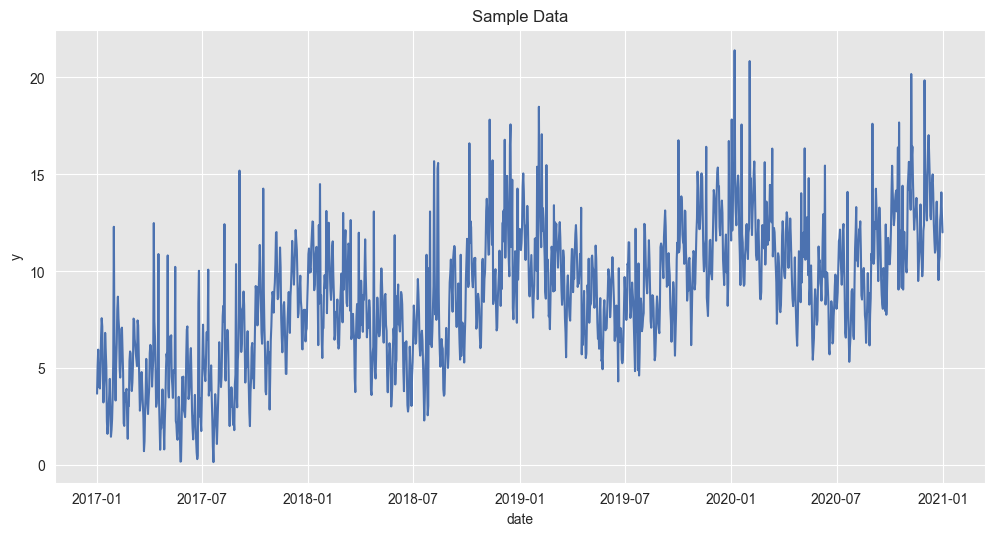

In [3]:
fig, ax = plt.subplots()
sns.lineplot(x='date', y='y', data=df, ax=ax)
ax.set(title='Sample Data');

In [4]:
forecasting_window = 30
training_window = 90

# df.set_index('date', inplace=True)

# df_train = df[: - forecasting_window]
# df_test = df[- forecasting_window :]

# y_train = df_train['y'].to_numpy()
# y_train = np.insert(arr=y_train, obj=y_train.shape, values=0)

# y_test = df_test['y'].to_numpy()

y = df['y'].to_numpy()
y = np.insert(arr=y, obj=y.shape, values=0)

In [5]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

y_wide = np.concatenate(
    [x for x, _  in TimeseriesGenerator(data=y, targets=y, length=forecasting_window)]
)

In [6]:
assert y_wide.shape == (y.shape[0] - forecasting_window, forecasting_window)

In [7]:
# y_train_wide_pad = np.insert(
#     arr=y_train_wide, 
#     obj=0, 
#     values=np.zeros(shape=(training_window, forecasting_window)), 
#     axis=0
# )

# zeros_df = pd.DataFrame(
#     data=np.zeros(shape=(training_window - forecasting_window + 1, df_train.shape[1])), 
#     columns=df_train.columns
# )

# df_train_pad = pd.concat([df_train, zeros_df], axis=0)

# df_train_pad.drop('date', axis=1)

# assert df_train_pad.shape[0] == y_train_wide_pad.shape[0]

In [20]:
features = [
    'x', 
    'day_of_month',
    'month',
    'day_of_week',
    #'y',
]

n_features = len(features)

In [21]:
data_gen = TimeseriesGenerator(
    data=df[features][: - (forecasting_window - 1)], 
    targets=y_wide, 
    length=training_window,
    batch_size=32
)

# data_gen = TimeseriesGenerator(
#     data=df[features], 
#     targets=y[:-1], 
#     length=training_window,
#     batch_size=32
# )

In [22]:
data_gen[0][0].shape

(32, 90, 4)

In [23]:
list(data_gen)[0][1].shape

(32, 30)

In [24]:
pd.DataFrame(list(data_gen)[0][0][0])

,0,1,2,3
0,0.0,1.0,1.0,6.0
1,0.0,2.0,1.0,0.0
2,0.0,3.0,1.0,1.0
3,0.0,4.0,1.0,2.0
4,0.0,5.0,1.0,3.0
...,...,...,...,...
85,0.0,27.0,3.0,0.0
86,0.0,28.0,3.0,1.0
87,0.0,29.0,3.0,2.0
88,0.0,30.0,3.0,3.0


In [25]:
df

,date,x,day_of_month,month,day_of_week,daysinmonth,y
0,2017-01-01,0.0,1,1,6,31,3.691835
1,2017-01-02,0.0,2,1,0,31,5.128892
2,2017-01-03,0.0,3,1,1,31,5.962151
3,2017-01-04,0.0,4,1,2,31,4.028831
4,2017-01-05,0.0,5,1,3,31,5.239363
...,...,...,...,...,...,...,...
1456,2020-12-27,0.0,27,12,6,31,12.629579
1457,2020-12-28,0.0,28,12,0,31,13.001715
1458,2020-12-29,0.0,29,12,1,31,14.070263
1459,2020-12-30,0.0,30,12,2,31,12.919764


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten

model = Sequential([
    LSTM(units=16, activation='relu', input_shape=(training_window, n_features), return_sequences=True),
    LSTM(units=16, activation='relu', return_sequences=False),
    Dense(units=forecasting_window, activation='linear')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 90, 16)            1344      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                510       
Total params: 3,966
Trainable params: 3,966
Non-trainable params: 0
_________________________________________________________________


In [27]:
from tensorflow.keras.losses import MeanAbsoluteError

model.compile(optimizer='adam', loss= MeanAbsoluteError(), metrics=['mse'])

history = model.fit(data_gen, epochs=20)

Epoch 1/20
42/42 [==============================] - 4s 41ms/step - loss: 9.4786 - mse: 107.3514
Epoch 2/20
42/42 [==============================] - 2s 40ms/step - loss: 8.7823 - mse: 93.9255
Epoch 3/20
42/42 [==============================] - 2s 43ms/step - loss: 7.2305 - mse: 70.7322
Epoch 4/20
42/42 [==============================] - 2s 42ms/step - loss: 5.5029 - mse: 48.8974
Epoch 5/20
42/42 [==============================] - 2s 38ms/step - loss: 5.3724 - mse: 42.2275
Epoch 6/20
42/42 [==============================] - 2s 39ms/step - loss: 4.0786 - mse: 27.9094
Epoch 7/20
42/42 [==============================] - 2s 39ms/step - loss: 3.2721 - mse: 17.9756
Epoch 8/20
42/42 [==============================] - 2s 39ms/step - loss: 2.6713 - mse: 11.8607
Epoch 9/20
42/42 [==============================] - 2s 41ms/step - loss: 2.5282 - mse: 10.4190
Epoch 10/20
42/42 [==============================] - 2s 48ms/step - loss: 2.4782 - mse: 10.0312
Epoch 11/20
42/42 [=============================

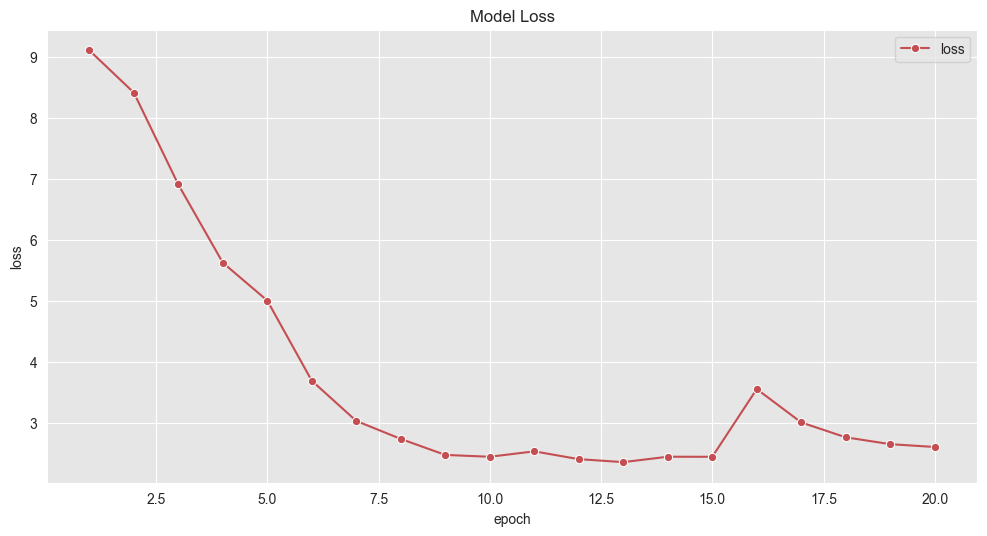

In [28]:
history_df = pd.DataFrame(history.history) \
    .reset_index(drop=False) \
    .eval('epoch = index + 1')

fig, ax = plt.subplots()
sns.lineplot(x='epoch', y='loss', data=history_df, color=sns_c[3], marker='o', label='loss', ax=ax)
ax.legend(loc='upper right')
ax.set(title='Model Loss');

In [16]:
predictions = model.predict(data_gen)

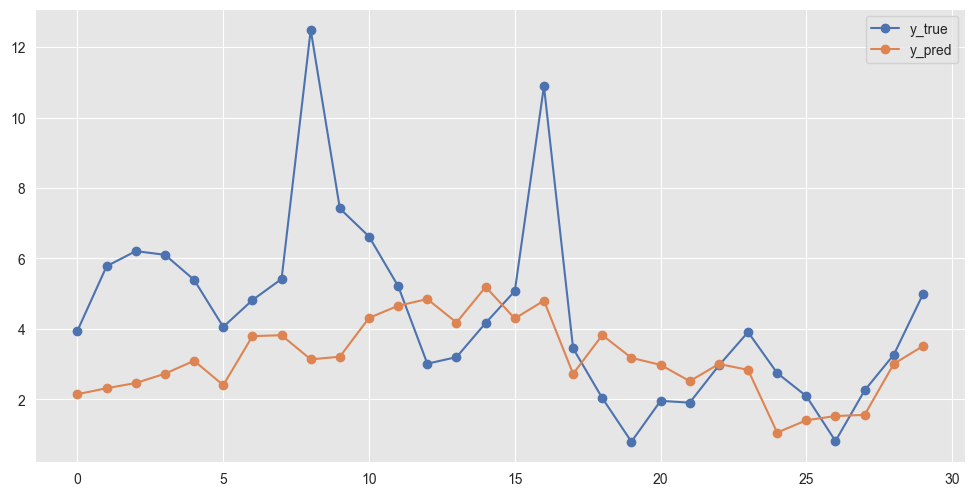

In [37]:
i = 0
fig, ax = plt.subplots()
ax.plot(data_gen[0][1][i], marker='o', label='y_true')
ax.plot(predictions[i, :], marker='o', label='y_pred')
ax.legend()

In [40]:
df.head(100)

,date,x,day_of_month,month,day_of_week,daysinmonth,y
0,2017-01-01,0.00000,1,1,6,31,3.691835
1,2017-01-02,0.00000,2,1,0,31,5.128892
2,2017-01-03,0.00000,3,1,1,31,5.962151
3,2017-01-04,0.00000,4,1,2,31,4.028831
4,2017-01-05,0.00000,5,1,3,31,5.239363
...,...,...,...,...,...,...,...
95,2017-04-06,0.00000,6,4,3,30,4.057262
96,2017-04-07,0.00000,7,4,4,30,4.817771
97,2017-04-08,0.00000,8,4,5,30,5.417902
98,2017-04-09,0.98246,9,4,6,30,12.487496
